**Name   : Srinivas Rengarajan <br>
Classification of 10 year Coronary Heart Disease Risk**

**Libraries imported and used in this Assignment:**<br><br>
***pandas,numpy, matplotlib, seaborn*** - For loading the data into dataframes, manipulating them, analysing and visualising them,<br>
***imblearn*** - For balancing the dataset,<br>
***sklearn*** - For preprocessing,building machine learning classifiers, performing gridsearch for hyperparameter optimization, validating and evaluation of those models using various metrics<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, average_precision_score, accuracy_score, precision_recall_curve, auc, f1_score
#For printing the values without calling print() function everytime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Variables used across this project

#Setting k=5 for 5 fold stratified cross validation
stratifiedkFold=StratifiedKFold(5,True,599)

#List of Categorical variables
categoricalVariables=['male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']

#List of Continuous variables
continuousVariables=['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

#List of metrics
metrics=["f1","roc_auc"]

#List of Balancing Methods used
balancingMethods=["Upsampling","Downsampling","SMOTE"]

#Setting the style for seaborn plots
sns.set(style="whitegrid")

#Classfier Objects
logregClassifier=LogisticRegression(random_state=599,solver="lbfgs",C=0.001)
#In general,in random forest, the good number for minimum samples for the tree to split is around 0.5 to 1% of the total training data.
#The default number for maximum features is the square root of the total number of features 
rfClassifier=RandomForestClassifier(random_state=599,min_samples_split=21,max_depth=5,max_features="sqrt")
svmClassifier=SVC(probability=True)
#As GBM is also a tree based algorithm, giving the same parameters as that of the random forest.
gbmClassifier=GradientBoostingClassifier(random_state=599,min_samples_split=21,max_depth=5,max_features="sqrt")

#Classifiers List
classifiers=[(logregClassifier,"LogisticRegression"),(rfClassifier,"RandomForest"),(svmClassifier,"SVM"),(gbmClassifier,"GBM")]

**Section 1**

****Dataset Description:***

The framingham dataset has been loaded as a data frame from the excel source. It contains 14 features and one response variable.
This is a dataset for binary classification. The response variable is **TenYearCHD**. There are 8 continuous valued features and 6 categorical encoded features in the dataset.

In [3]:
def importData():
    
    #Read the data from excel file into a dataframe 
    framingham_df=pd.read_excel("framingham.xlsx")
    return framingham_df

framingham_df=importData()
#Dataset preview
framingham_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**Section 2**
**Exploratory Data Analysis and Data Pre-Processing**

**2.1-Dataset Information**

In [4]:
framingham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
male               4240 non-null int64
age                4240 non-null int64
currentSmoker      4240 non-null int64
cigsPerDay         4211 non-null float64
BPMeds             4187 non-null float64
prevalentStroke    4240 non-null int64
prevalentHyp       4240 non-null int64
diabetes           4240 non-null int64
totChol            4190 non-null float64
sysBP              4240 non-null float64
diaBP              4240 non-null float64
BMI                4221 non-null float64
heartRate          4239 non-null float64
glucose            3852 non-null float64
TenYearCHD         4240 non-null int64
dtypes: float64(8), int64(7)
memory usage: 497.0 KB


In [5]:
#Get the descriptive statistics for continuous features
framingham_df.iloc[:,[1,3,8,9,10,11,12,13]].describe()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4240.000000,4211.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000
mean,49.580189,9.005937,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655
std,8.572942,11.922462,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335
min,32.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000
50%,49.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000
75%,56.000000,20.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000
max,70.000000,70.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000


**2.2-Value Counts**

0    3596
1     644
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 84.81132075471697


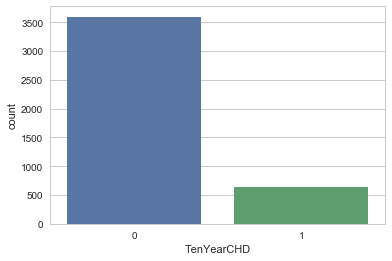

In [6]:
#To get the value counts of the target variable in the provided dataframe and visualise them in plots
def countClass(df):
    
    print(df["TenYearCHD"].value_counts())
    print("\n")
    print("The majority class (0) percentage is:",(df["TenYearCHD"].value_counts()[0]/(df["TenYearCHD"].value_counts()[0]+df["TenYearCHD"].value_counts()[1]))*100)
    #To Visualise the count of subjects in both NoRisk and Risk class via pandas bar plot
    sns.countplot("TenYearCHD", data=df)
    plt.show()
    
countClass(framingham_df)    

**2.3-Correlation Heatmap analysis**

From the correlation heat map, we can see that no individual indpendent variable has a stronger correlation with the outcome variable and also the variables like diabetes-glucose, sysBP-diaBP and prevalentHyp-sysBP are strongly correlated. The maximum correlation of a variable with TenYearCHD is age and sysBP about 0.3

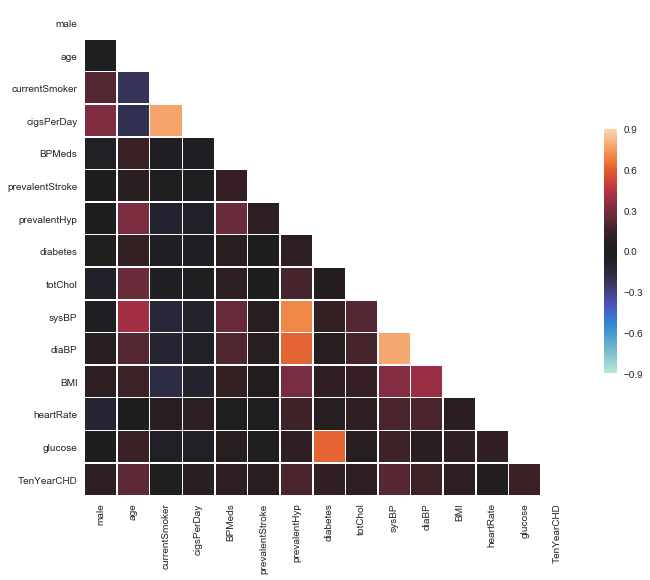

In [7]:
#To visualise the correlation between the variables and the target using correlation matrix heatmap
def visualiseCorrelation(framingham_df):
    
    correlation_matrix=framingham_df.corr()
    #Masking the upper triangle
    uppertrianglemask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
    #Setting up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    #Customised heatmap
    sns.heatmap(correlation_matrix, mask=uppertrianglemask, vmin= -.9, vmax=.9, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

visualiseCorrelation(framingham_df)

**2.4-Missing Data Information**

CigsPerDay, BPMeds, totChol, BMI, heartRate and glucose have missing values. Even though, the proportion of the missing values are not that high, they are imputed as we already did not have enough records. The continuous valued columns are replaced by the medain of that column and the categorical variables are replaced by their mode.

In [8]:
def checkMissingValues(framingham_df):
    # Check for Missing values in each variable
    print(framingham_df.isna().sum())
    
checkMissingValues(framingham_df)    

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


**2.5-Missing Data Imputation**

In [9]:
def fillMissingValues(framingham_df):
    
    for i, column in enumerate(framingham_df.columns):
        if column not in categoricalVariables:
            framingham_df[column].fillna(framingham_df[column].median(), inplace=True)
        else:
            framingham_df[column].fillna(stats.mode(framingham_df[column]).mode[0], inplace=True)
            
fillMissingValues(framingham_df)    
checkMissingValues(framingham_df)    

male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


**2.6-Visualising the Distribution of each variable**

The distribution of the variables in the dataset tells us many things.

1)Female patients are more in numbers than to male<br>
2)Age is positively skewed or right skewed<br>
3)The persons who are currently having the smoking habbit are almost equal in numbers to that of the non-smokers<br>
4)More number of people are not taking blood pressure medications<br>
5)More number of people do not have prevalent stoke earlier<br>
6)PrevalentHyp is not balanced<br>
7)More number of people do not have diabetes<br>
8)All the other vital and potential high risk parameters are normally distributed<br>


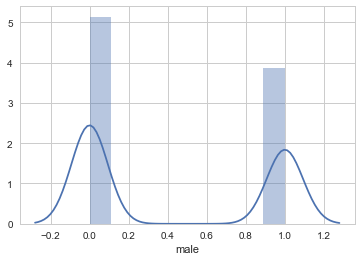

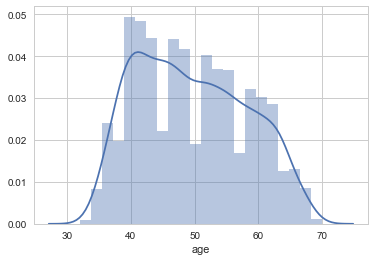

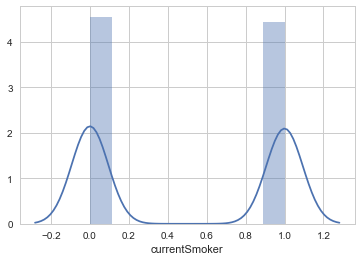

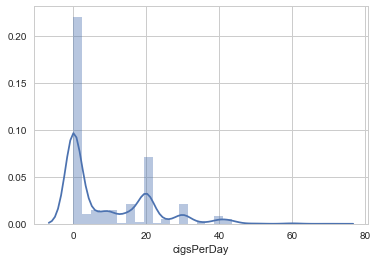

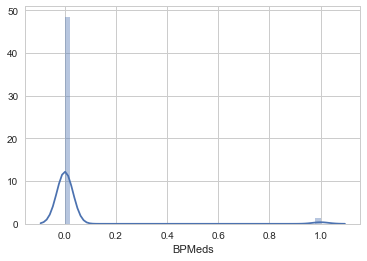

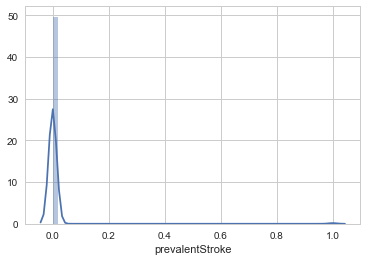

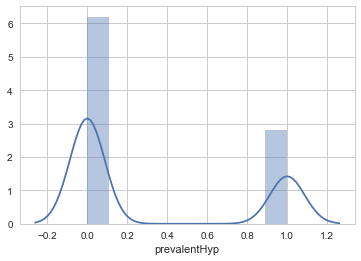

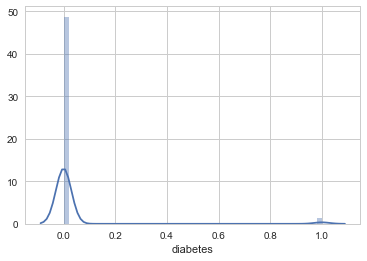

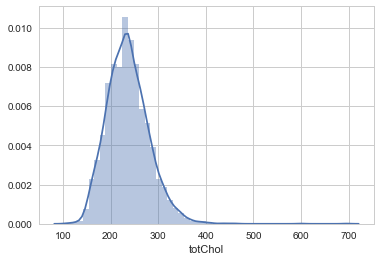

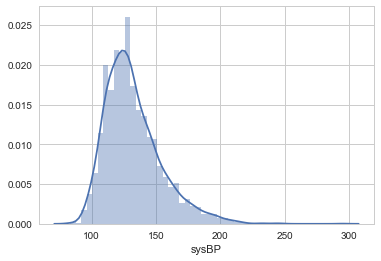

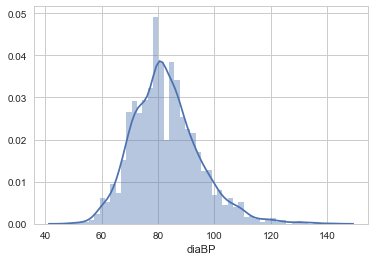

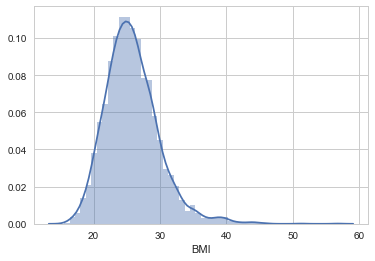

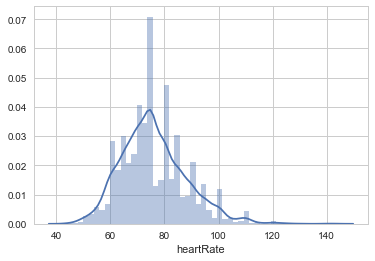

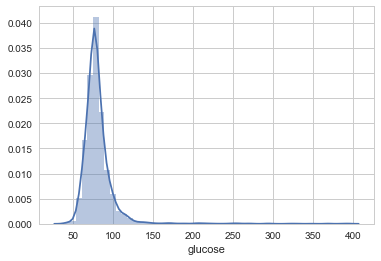

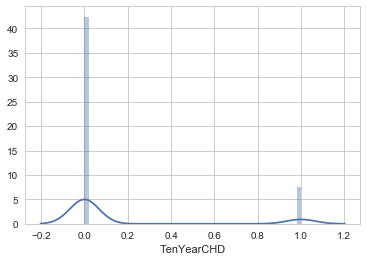

In [10]:
def histograms(framingham_df):
    
    for i, column in enumerate(framingham_df.columns):
        
        plt.figure(i)
        #Visualize the distribution of the data
        sns.distplot(framingham_df[column])
        plt.show()           

histograms(framingham_df) 

**2.7**

In [11]:
#Given the dataframe, split it into features and response
def splitFeaturesTargets(framingham_df):
    
    x=framingham_df.loc[:, framingham_df.columns != 'TenYearCHD']
    y=framingham_df.loc[:,'TenYearCHD']
    return x,y

x,y=splitFeaturesTargets(framingham_df)

**2.8**
To find the feature importance, a random forest classifier was trained keeping the weights balanced and the importance is plotted.

On seeing the feature importance plot, we can see only the age,sysBP,BMI,totChol,diaBP,glucose,heartRate and cigsPerDay are relatively important while others does not add any value to the model and are potentially noise. So, we are removing them from the dataset

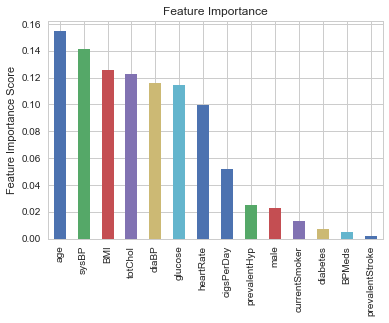

In [12]:
#To find the feature importance, a random forest classifier was trained keeping the weights balanced and the importance is plotted
def featureImportance():
    
    rfModel = RandomForestClassifier(random_state=599, n_estimators=1000, n_jobs=-1, class_weight='balanced')
    rfModel.fit(x,y)
    feat_imp = pd.Series(rfModel.feature_importances_, x.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importance')
    plt.ylabel('Feature Importance Score')
    
featureImportance()    

**2.9**
Removing the less important variables from the dataframe. It could be seen from the above plot that the variables 'currentSmoker', 'male','prevalentHyp','BPMeds','diabetes','prevalentStroke' have very less importance in finding the TenYearCHD.

In [13]:
framingham_df.drop(['currentSmoker', 'male','prevalentHyp','BPMeds','diabetes','prevalentStroke'], axis=1, inplace=True)
x,y=splitFeaturesTargets(framingham_df)

**2.10**
Given a Dataframe, split into training and testing dataframes in 80/20 proportions.

In [14]:
def createDataPartition(framingham_df):  
    
     #Resetting the index
    framingham_df=framingham_df.reset_index(drop=True)
    
    #Splitting the data into training and testing in 80/20 proportions
    framingham_train_df=framingham_df.sample(frac=0.80,random_state=599)#random state is used for setting the seed value for reproducibility
    framingham_test_df=framingham_df.drop(framingham_train_df.index)

    #Resetting the index for clear understanding
    framingham_train_df=framingham_train_df.reset_index(drop=True)
    framingham_test_df=framingham_test_df.reset_index(drop=True)
    
    return framingham_train_df,framingham_test_df


**2.11-Data Partition**

The framingham dataframe has been split into respective train and test dataframes in 80/20 proportion

In [15]:
x_train_df,x_test_df=createDataPartition(framingham_df)
x_train,y_train=splitFeaturesTargets(x_train_df)
x_test,y_test=splitFeaturesTargets(x_test_df)

**2.13-Standardization Function**
The below function will do standardization provided a training and testing dataframe.
Standardization is the process of bringing all the data into a same scale which would be easy for the classifiers to learn.
The data is subtracted from its mean and divided by its standard deviation. This process is called scaling and centering.

In [16]:
def standardizeData(framingham_train_df,framingham_test_df):
    
    scaler = preprocessing.StandardScaler().fit(framingham_train_df[continuousVariables].values)
    standardizedTrain = scaler.transform(framingham_train_df[continuousVariables].values)
    standardizedTest = scaler.transform(framingham_test_df[continuousVariables].values)
    
    framingham_train_df[continuousVariables]=standardizedTrain
    framingham_test_df[continuousVariables]=standardizedTest 
    
    return framingham_train_df,framingham_test_df

**2.12**
**Balancing the Data using random UpSampling, random DownSampling and SMOTE **

The dataset is balanced using three techniques as above. 

For random Upsampling and random downsampling:
1)The training dataset is resampled using resample method with replacement
2)The training dataset is fitted and transformed with StandardScaler and the test set data is also transformed with the same fitted standard scaler object.
3)The data is splitted into features and response using splitFeaturesTargets function.

For SMOTE:
1)The benefit of SMOTE is increased when combined with undersampling according to SMOTE documentation and paper by Chawla.
2)So, an imbalanced learn Pipeline has been created for executing the same and then the smote object was fitted on the x and y.
3)Then they are standardized using the standard scaler as above.
4)The data is then splitted into features and response using splitFeaturesTargets function.

After Upsampling: 

1    3596
0    3596
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 50.0


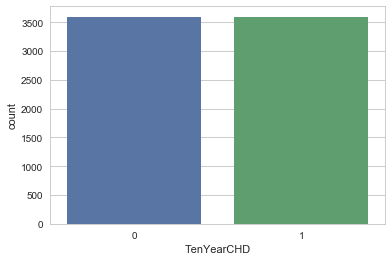

After Partitioning Upsampled Data into Train and Test set with 80:20 ratio: 

Training set: 

1    2888
0    2866
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 49.80882864094543


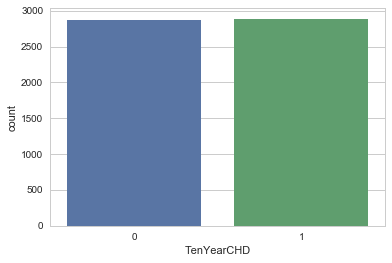

Testing set: 

0    730
1    708
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 50.76495132127955


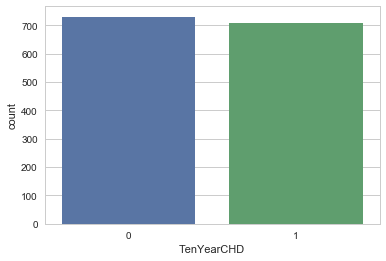

After Standardizing the Data: 

Training Set: 

        age  cigsPerDay   totChol     sysBP     diaBP       BMI  heartRate  \
0 -1.548912   -0.772004 -1.532158 -0.890656 -1.914862  0.168147  -0.924208   
1  1.935367   -0.772004 -0.237358 -0.521271 -1.131148 -0.772997  -0.509932   

    glucose  TenYearCHD  
0 -0.792496           0  
1 -0.792496           0  
Testing Set: 

        age  cigsPerDay   totChol     sysBP     diaBP       BMI  heartRate  \
0 -1.432769   -0.772004 -0.980276 -1.260042 -1.131148  0.191558   0.318619   
1 -0.968198   -0.772004 -0.279811  1.777129  2.003707  0.971163   0.070054   

    glucose  TenYearCHD  
0 -0.235341           0  
1  0.485684           0  
After Downsampling: 

1    644
0    644
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 50.0


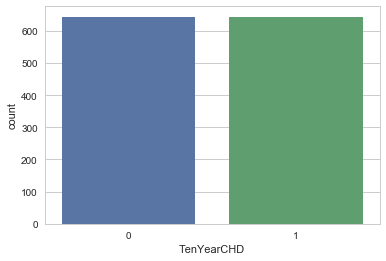

After Partitioning Downsampled Data into Train and Test set with 80:20 ratio: 

Training set: 

1    519
0    511
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 49.61165048543689


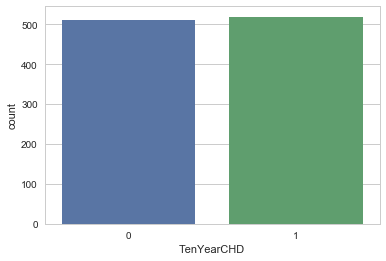

Testing set: 

0    133
1    125
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 51.55038759689923


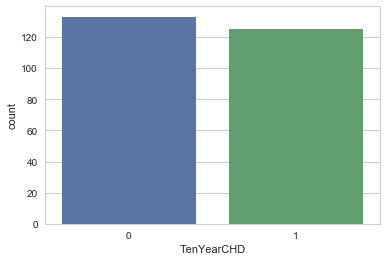

After SMOTE oversampling: 

      age  cigsPerDay     totChol       sysBP       diaBP        BMI  \
0      62    0.000000  282.000000  175.000000   79.000000  28.240000   
1      41   11.000000  201.000000  108.000000   71.000000  20.470000   
2      62    0.000000  242.000000  130.000000   91.000000  31.120000   
3      51    0.000000  250.000000  125.000000   80.000000  26.980000   
4      43   20.000000  204.000000  133.000000   86.500000  26.010000   
5      38    0.000000  197.000000  121.000000   82.000000  24.570000   
6      56    3.000000  266.000000  114.000000   72.000000  22.640000   
7      61    0.000000  271.000000  122.000000   67.500000  22.020000   
8      50    0.000000  258.000000  127.000000   80.000000  24.100000   
9      59    1.000000  259.000000  141.000000   86.000000  25.970000   
10     62    0.000000  308.000000  152.000000   98.000000  35.420000   
11     36   35.000000  295.000000  102.000000   68.000000  28.150000   
12     50   20.000000  265.000000  1

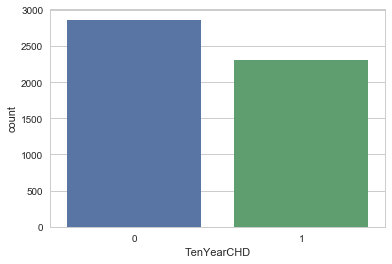

Testing set: 

0    731
1    563
Name: TenYearCHD, dtype: int64


The majority class (0) percentage is: 56.49149922720247


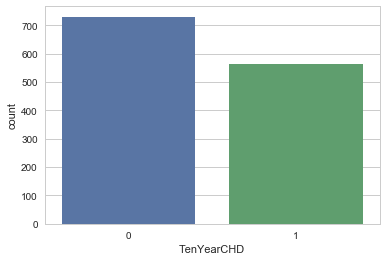

After Standardizing the SMOTEd Data: 

Training Set: 

        age  cigsPerDay   totChol     sysBP     diaBP       BMI  heartRate  \
0 -1.202756    1.757735  1.192970  0.693953 -0.916001 -0.208661  -0.095659   
1  0.947543   -0.769859  0.224027  0.135062 -0.384155 -0.703476   1.538016   

    glucose  TenYearCHD  
0  0.981310           0  
1 -0.197878           0  
Testing Set: 

        age  cigsPerDay   totChol     sysBP     diaBP       BMI  heartRate  \
0  1.305926   -0.769859  0.967635  1.682760 -0.425066  0.568175  -1.643351   
1 -0.963834    0.915204 -0.789983 -0.122888  0.188603 -0.003556   2.053913   

    glucose  TenYearCHD  
0 -0.579380           0  
1 -0.163196           0  


In [17]:
def resampling(framingham_df, resampling):
    
    #Separating Majority and Minority classes into two different dataframes
    framingham_majority_df=framingham_df[framingham_df.TenYearCHD==0].copy()
    framingham_minority_df=framingham_df[framingham_df.TenYearCHD==1].copy()
    
    if resampling=="Upsampling":
        print("After Upsampling: \n")
        #Random upsampling of minority class with replacement
        framingham_minority_df_upsampled=resample(framingham_minority_df,replace=True,n_samples=3596, random_state=599)
        #Combining the upsampled minority df with majority df into a new dataframe
        framingham_upsampled_df=pd.concat([framingham_majority_df,framingham_minority_df_upsampled])
        countClass(framingham_upsampled_df)
        framingham_upsampled_train_df, framingham_upsampled_test_df = createDataPartition(framingham_upsampled_df)
        print("After Partitioning Upsampled Data into Train and Test set with 80:20 ratio: \n")
        print("Training set: \n")
        countClass(framingham_upsampled_train_df)
        print("Testing set: \n")
        countClass(framingham_upsampled_test_df)
        framingham_upsampled_train_df,framingham_upsampled_test_df=standardizeData(framingham_upsampled_train_df,framingham_upsampled_test_df)        
        print("After Standardizing the Data: \n")
        print("Training Set: \n")
        print(framingham_upsampled_train_df.head(2))
        print("Testing Set: \n")
        print(framingham_upsampled_test_df.head(2))
        x_upsampled_train,y_upsampled_train=splitFeaturesTargets(framingham_upsampled_train_df)
        x_upsampled_test,y_upsampled_test=splitFeaturesTargets(framingham_upsampled_test_df)
        return x_upsampled_train,y_upsampled_train,x_upsampled_test,y_upsampled_test

    elif resampling=="Downsampling":
        print("After Downsampling: \n")
        #Random downsampling of majority class without replacement
        framingham_majority_df_downsampled=resample(framingham_majority_df,replace=False,n_samples=644, random_state=599)
        #Combining the downsampled majority df with minority df into a new dataframe
        framingham_downsampled_df=pd.concat([framingham_majority_df_downsampled,framingham_minority_df])
        countClass(framingham_downsampled_df)
        framingham_downsampled_train_df, framingham_downsampled_test_df = createDataPartition(framingham_downsampled_df)
        print("After Partitioning Downsampled Data into Train and Test set with 80:20 ratio: \n")
        print("Training set: \n")
        countClass(framingham_downsampled_train_df)
        print("Testing set: \n")
        countClass(framingham_downsampled_test_df)
        framingham_downsampled_train_df, framingham_downsampled_test_df=standardizeData(framingham_downsampled_train_df,framingham_downsampled_test_df)   
        x_downsampled_train,y_downsampled_train=splitFeaturesTargets(framingham_downsampled_train_df)
        x_downsampled_test,y_downsampled_test=splitFeaturesTargets(framingham_downsampled_test_df)
        return x_downsampled_train,y_downsampled_train,x_downsampled_test,y_downsampled_test
    
    else:
        print("After SMOTE oversampling: \n")
        over = SMOTE(random_state=599, sampling_strategy=0.8) #setting random_state for reproducibility
        under = RandomUnderSampler(random_state=599, sampling_strategy=0.8)
        steps = [('o', over), ('u', under)]
        #Creating an imbalanced learn pipeline for SMOTE oversampling combined with undersampling
        pipeline = Pipeline(steps=steps)

        # transform the dataset
        x_train_smote, y_train_smote = pipeline.fit_resample(x,y)
        print(x_train_smote)
        print("1  ",len(y_train_smote[y_train_smote==1]),"\n")
        print("0  ",len(y_train_smote[y_train_smote==0]),"\n")
        newDf=pd.concat([x_train_smote, y_train_smote], axis=1) 
        framingham_smoted_train_df, framingham_smoted_test_df = createDataPartition(newDf)
        print("After Partitioning Smoted Data into Train and Test set with 80:20 ratio: \n")
        print("Training set: \n")
        countClass(framingham_smoted_train_df)
        print("Testing set: \n")
        countClass(framingham_smoted_test_df)
        framingham_smoted_train_df, framingham_smoted_test_df=standardizeData(framingham_smoted_train_df,framingham_smoted_test_df)  
        print("After Standardizing the SMOTEd Data: \n")
        print("Training Set: \n")
        print(framingham_smoted_train_df.head(2))
        print("Testing Set: \n")
        print(framingham_smoted_test_df.head(2))
        x_train_smote,y_train_smote=splitFeaturesTargets(framingham_smoted_train_df)
        x_test_smote,y_test_smote=splitFeaturesTargets(framingham_smoted_test_df)
        return x_train_smote,y_train_smote,x_test_smote,y_test_smote
        

x_upsampled_train,y_upsampled_train,x_upsampled_test,y_upsampled_test = resampling(framingham_df,"Upsampling")    
x_downsampled_train,y_downsampled_train,x_downsampled_test,y_downsampled_test = resampling(framingham_df,"Downsampling")
x_train_smote,y_train_smote,x_test_smote,y_test_smote = resampling(framingham_df,"SMOTE")

**Section-3**

**3.1-Function for training the classifiers-It takes classifier object, classifier name, x and y as parameters**

1)The function does stratified 5 fold cross validation for the given x train and y train objects using the given classifier and 
evaluated on both of the f1 score and roc_auc metric.
2)Then the results across each fold are averaged and outputted.

In [18]:
def trainClassifier(classifier,classifierName,x_train,y_train):
    
    print("\nResults for",classifierName,": \n")
    for metric in metrics:
        #Out-of-sample evaluation using stratified k fold cross validation
        classifier_results=cross_val_score(classifier,x_train,y_train,cv=stratifiedkFold,scoring=metric)
        classifier_results=np.fromiter(map(lambda x: round(x,2),classifier_results),dtype=np.float)
        print("Cross-Validation ",metric,"for each fold:")
        print(classifier_results)
        #Averaged cross-validation score 
        print("Averaged Cross-Validation ",metric ,"is ",round(classifier_results.mean(),2),"\n")   


**3.2-Test Classifier**

1)Given a classifier, train and test data, this function fits the classifier with the training data and predicts the test data.
2)It also predicts the probabaility estimates for the test data and slice the positive class estimates 
3)A confusion matrix is created with the true and predicted values and true positive, false negative, false positive and true negative values are obtained from them 
4)Precision, Recall and Thresholds value are obtained from precision_recall_curve function of the true and predicted positive class probabilities.
5)The evaluation metrics used on the test data are True Positive Rate(Recall or Sensitivity) and Precision_Recall_Auc score. Sensitivity is the proportion of actual number of positive samples that got classified as positive.
Precision_Recall is a successive evaluation metric for the imbalanced data problem as they concentrate on the minotity class.
Precision tells how much the result is relevant and recall is the measure of how many truly relevant results are obtained.

In [19]:
def testClassifier(classifier,name,x_train,y_train,x_test,y_test):
    classifier.fit(x_train,y_train)
    y_predicted=classifier.predict(x_test)
    y_predicted_probs=classifier.predict_proba(x_test)
    #Probabilities of Positive Class
    y_predicted_probs=y_predicted_probs[:,1]
    labels = [0, 1]
    confusionMatrix = confusion_matrix(y_test, y_predicted, labels)
    print(confusionMatrix)
    tn, fp, fn, tp=confusion_matrix(y_test, y_predicted).ravel()
    precision, recall, thresholds = precision_recall_curve(y_test, y_predicted_probs)
    print("True Positives:",tp, "True Negatives:", tn, "False Positives:", fp, "False Negatives:", fn,"\n")
    print("True Positve Rate (Recall) is ",round(tp/(tp+fn),2),"\n")
    print("The Precision_Recall_AUC_score is ", round(auc(recall, precision),2),"\n")
    print("The Accuracy is ", round(accuracy_score(y_test,y_predicted),2))
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

**3.3-Function to call the trainClassifier() for each of the classifier**

Four different classifiers are used in this project. They are Logistic Regression, Support Vector Machine, Random Forest and Gradient Boosting Machine (GBM). Logistic Regression and SVM are non tree base models whereas Random Forest and GBM are tree based.


In [20]:
def runClassifiers(x_train,y_train):
    
    for classifier in classifiers:
        trainClassifier(classifier[0],classifier[1],x_train,y_train)


**3.4**
**Training the classifiers and analysing the Cross validated out-of-sample performances**

From the results, we can see that, GBM model generally peroforms well across the techniques (Upsampling and SMOTE oversampling) although the logistic regression performs well in Downsampling. We selected GBM from SMOTE for the final classfication and evaluation on test data along with Logistic Regression for Cost sensitive learning. These two classifiers are hyperparamter optimized and again evaluation is done by calling the testClassifier function.

In [21]:
#Analyse the out-of-sample cross-validated classification results for the different techniques applied to balance the data 
def analyseResamplingResults(resampling):
    
    if resampling=="Upsampling":
        print("\nAfter Upsampling: \n")
        runClassifiers(x_upsampled_train,y_upsampled_train)
    elif resampling=="Downsampling":
        print("\nAfter Downsampling: \n")
        runClassifiers(x_downsampled_train,y_downsampled_train) 
    else:
        print("\nAfter SMOTE: \n")
        runClassifiers(x_train_smote,y_train_smote)

analyseResamplingResults("Upsampling")
analyseResamplingResults("Downsampling")
analyseResamplingResults("SMOTE")


After Upsampling: 


Results for LogisticRegression : 

Cross-Validation  f1 for each fold:
[0.64 0.68 0.66 0.65 0.64]
Averaged Cross-Validation  f1 is  0.65 

Cross-Validation  roc_auc for each fold:
[0.7  0.74 0.7  0.72 0.69]
Averaged Cross-Validation  roc_auc is  0.71 


Results for RandomForest : 

Cross-Validation  f1 for each fold:
[0.69 0.73 0.71 0.71 0.7 ]
Averaged Cross-Validation  f1 is  0.71 

Cross-Validation  roc_auc for each fold:
[0.74 0.79 0.74 0.76 0.75]
Averaged Cross-Validation  roc_auc is  0.76 


Results for SVM : 

Cross-Validation  f1 for each fold:
[0.69 0.71 0.69 0.69 0.68]
Averaged Cross-Validation  f1 is  0.69 

Cross-Validation  roc_auc for each fold:
[0.74 0.78 0.75 0.75 0.74]
Averaged Cross-Validation  roc_auc is  0.75 


Results for GBM : 

Cross-Validation  f1 for each fold:
[0.78 0.82 0.79 0.79 0.78]
Averaged Cross-Validation  f1 is  0.79 

Cross-Validation  roc_auc for each fold:
[0.87 0.89 0.86 0.87 0.85]
Averaged Cross-Validation  roc_auc is  0.87 


**Section-4**

**4.1**
**Selecting GBM From SMOTE Oversampling as one of the final models For Test Set Evaluation and HyperParameter Tuning**

**Before GBM Tuning**
For GBM, before tuning we can see that The precision_recall_auc score is 0.86 and the true positive rate (Sensitivity) is around 0.75. This can be eventhough acceptable, hyperparameter tuning is done further to improvise the precision_recall_auc score as positive results are more important than negative results in our problem. The precision_recal_auc curve is plotted for different thresholds below.

Before GBM Tuning: 

[[602 129]
 [138 425]]
True Positives: 425 True Negatives: 602 False Positives: 129 False Negatives: 138 

True Positve Rate (Recall) is  0.75 

The Precision_Recall_AUC_score is  0.86 

The Accuracy is  0.79


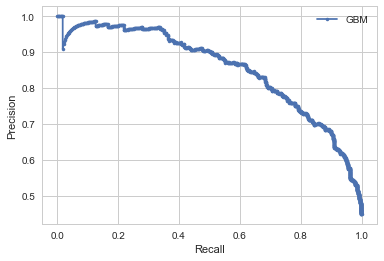

In [22]:
print("Before GBM Tuning: \n")
testClassifier(gbmClassifier,"GBM",x_train_smote,y_train_smote,x_test_smote,y_test_smote)

**4.2-HyperParameter Tuning of GBM**

GBM is a tree based ensemble model. It works on many iterations (as many number of trees as the no of estimators). For evey iteration, it learns the differentiable loss function from the previous iteration and tries to minimise it in the current iteration. The best parameters obtained for learning rate is 0.1, number of estimators is 90, minimum number of samples to split the tree is 20, maximum no features to be considered for tree splitting is  7, subsample size is 0.7. Finally the maximum depth of the tree is tuned and got the optimal result for it as 8.

In [23]:
def gbmTuning():
    param_test_gbm = {'max_depth':range(4,9)}
    gbm_grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=90,min_samples_split=20,max_features=7,subsample=0.7,random_state=599), 
    param_grid = param_test_gbm, n_jobs=4,iid=False, cv=5, scoring="f1")
    gbm_grid.fit(x_train_smote,y_train_smote)
    print(gbm_grid.best_params_, gbm_grid.best_score_)
    return gbm_grid
gbm_grid=gbmTuning()

{'max_depth': 8} 0.8309592466904057


**After GBM Tuning**
The best estimators obtianed on GBM tuning are applied on the test set and evaluated. We can see the results have been significantly improved after tuning, from 0.86 for precision_recall_auc before tuning to 0.92 after hyperparameter tuning.
The precision recall curve is also plotted. And also the true positive rate is also increased from 0.75 to 0.8 after tuning the model. This result can be considered for the Coronary Heart Disease Risk classification problem.

After GBM Tuning: 

[[664  67]
 [114 449]]
True Positives: 449 True Negatives: 664 False Positives: 67 False Negatives: 114 

True Positve Rate (Recall) is  0.8 

The Precision_Recall_AUC_score is  0.92 

The Accuracy is  0.86


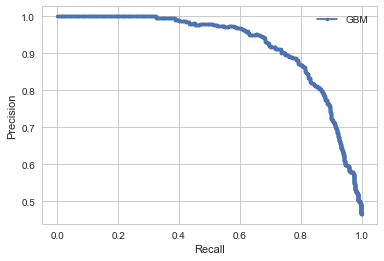

In [24]:
print("After GBM Tuning: \n")
testClassifier(gbm_grid.best_estimator_,"GBM",x_train_smote,y_train_smote,x_test_smote,y_test_smote)

**4.3**
**Handling Data Imbalance using Cost Sensitive Learning**

**Selecting Logistic Regression for Cost Sensitive Learning as the other final model For Test Set Evaluation and Hyperparameter Tuning****

**Before Cost Sensitive Logistic Regression Tuning**
As this is a cost sensitive learning method, our main aim is to increase the true positive rate. We cannot afford for false negative predictions. Initially, the class-weight parameter in logistic regression is set to be balanced and the model is trained and evaluated on the test data. We got the True Positive Rate as 0.65. It is so less. So, for getting optimal estimators, we further tuned logistic regression classifier for different misclassification weights and the C parameter which is the regularization parameter.

Before Cost Sensitive Logistic Regression Tuning: 

[[465 253]
 [ 46  84]]
True Positives: 84 True Negatives: 465 False Positives: 253 False Negatives: 46 

True Positve Rate (Recall) is  0.65 

The Precision_Recall_AUC_score is  0.32 

The Accuracy is  0.65


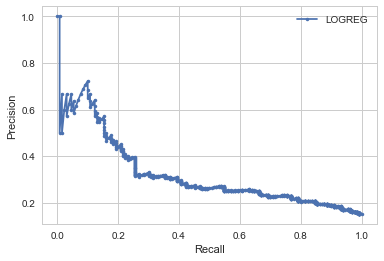

In [25]:
print("Before Cost Sensitive Logistic Regression Tuning: \n")
testClassifier(LogisticRegression(random_state=599,solver="lbfgs",class_weight="balanced"),"LOGREG",x_train,y_train,x_test,y_test)

**4.4-HyperParameter Tuning of Cost Sensitive Logistic Regression**
The best class weight parameter obtained is 1 for the negative class and 10 for the positive class.
The best regularization parameter obtained is 0.1. 

In [26]:
def logregTuning():
    balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
    param_grid = {'C': [0.0001,0.005,0.001, 0.01, 0.09, 0.1, 1, 10, 100, 1000],'class_weight':balance }
    clf = GridSearchCV(LogisticRegression(penalty='l2', solver="lbfgs", random_state=599), param_grid,cv=5,scoring='f1')
    clf.fit(x_train,y_train)
    print(clf.best_params_, clf.best_score_)
    return clf
clf=logregTuning()

{'C': 0.1, 'class_weight': {0: 1, 1: 10}} 0.33713892727660066


**After Logistic Regression Cost Sensitive Tuning**
The model with the optimal estimators are then trained and evaluated on the test set. We see that the true positive rate has increased significantly from 0.65 to 0.85 and the precision_recall_auc score is the same as we only got more number of false positives now. This is the only trade-off in this method. But we prefer positive class more than the negative class. A patient potentially having the risk of CHD should not be classified as not having the risk as this is more dangerous. The precision_recall curve is also plotted.

Cost Sensitive Logistic Regression After Tuning: 

[[282 436]
 [ 20 110]]
True Positives: 110 True Negatives: 282 False Positives: 436 False Negatives: 20 

True Positve Rate (Recall) is  0.85 

The Precision_Recall_AUC_score is  0.32 

The Accuracy is  0.46


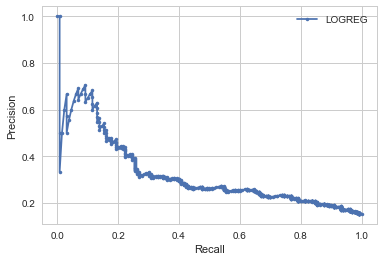

In [27]:
print("Cost Sensitive Logistic Regression After Tuning: \n")
testClassifier(clf.best_estimator_,"LOGREG",x_train,y_train,x_test,y_test)